Define and test functions for calculating statistical quantities of interest from an arbitrary probability density function.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from typing import Union

In [3]:
def marginalize(
    pdf: xr.DataArray,
    dim: str | list = None,
    bin_widths: dict[str, Union[float, np.array, xr.DataArray]] = None,
) -> xr.DataArray:
    """
    Find the marginal probability distribution from the joint pdf.
    
    Integrates out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
        
    if isinstance(dim, str):
        dims = [dim]
 
    #all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
   
    #if dims is None:
    #    raise ValueError
    #    dims = all_bin_dims
    #if any(d not in all_bin_dims for d in dims):
    #    raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")

    if bin_widths is None:
        # Use defaults from vort/strain/div JPDF
        bin_widths = {
            'vort_bin': pdf['vort_bin'].diff('vort_bin')[0],
            'strain_bin': pdf['strain_bin'].diff('strain_bin')[0],
            'div_bin': pdf['div_bin'].diff('div_bin')[0],
        }
    
    marginal_pdf = pdf
    for bin_dim in dim:
        # TODO these would be slightly more accurate if we used xarray's integrate function
        marginal_pdf = marginal_pdf.sum(dim=bin_dim) * bin_widths[bin_dim]
        
    return marginal_pdf


def expectation(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x, dim=dim, bin_widths=bin_widths)

In [4]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dim: str | list = None, bin_widths=None) -> xr.DataArray:
        return marginalize(self._da, dim, bin_widths)
    
    def expectation(self, x, dim: str | list = None, bin_widths=None) -> xr.DataArray:
        return expectation(self._da, x, dim, bin_widths)

In [5]:
def remove_bins_suffix(da: xr.DataArray) -> xr.DataArray:
    """Removes the suffix '_bins' from the name of the dataarray if present."""
    if da.name is not None and da.name.endswith("_bin"):
        return da.rename(da.name.removesuffix('_bin'))
    else:
        return da

    
def mean(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    mu = expectation(pdf, x, dim, bin_widths)
    return remove_bins_suffix(mu)


def variance(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    mu = mean(pdf, x, dim, bin_widths)
    var = expectation(pdf, (x - mu) ** 2, dim, bin_widths)
    return remove_bins_suffix(var)


def standard_deviation(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    return np.sqrt(variance(pdf, x, dim, bin_widths))
mean

def skewness(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    mu = mean(pdf, x, dim, bin_widths)
    sigma = standard_deviation(pdf, x, dim, bin_widths)
    skew = expectation(pdf, (x - mu) ** 3, dim, bin_widths) / (sigma ** 3)
    return remove_bins_suffix(skew)


def kurtosis(pdf: xr.DataArray, x: xr.DataArray, dim: str | list = None, bin_widths=None) -> xr.DataArray:
    mu = mean(pdf, x, dim, bin_widths)
    sigma = standard_deviation(pdf, x, dim, bin_widths)
    kurt = expectation(pdf, (x - mu) ** 4, dim, bin_widths) / (sigma ** 4) - 3
    return remove_bins_suffix(kurt)

## Test

### Normal distribution

In [6]:
from scipy.stats import norm

In [7]:
rv = norm(loc=1.5, scale=3)

In [8]:
rv

In [9]:
x = np.linspace(rv.ppf(0.0001),
                rv.ppf(0.9999), 10000)

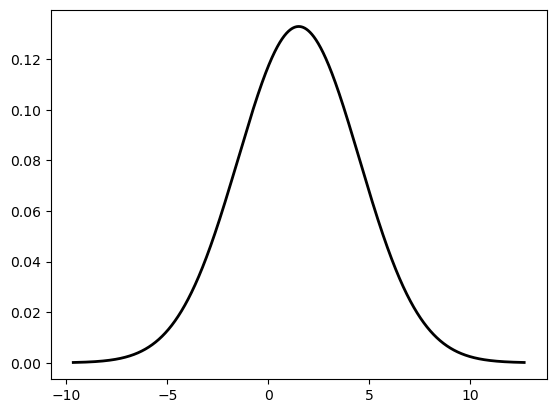

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [11]:
rv.std()

3.0

In [12]:
pdf = xr.DataArray(data=rv.pdf(x), dims=['x'], coords={'x': x})
pdf

<xarray.DataArray (x: 10000)>
array([0.00013195, 0.00013231, 0.00013268, ..., 0.00013268, 0.00013231,
       0.00013195])
Coordinates:
  * x        (x) float64 -9.657 -9.655 -9.653 -9.65 ... 12.65 12.65 12.65 12.66

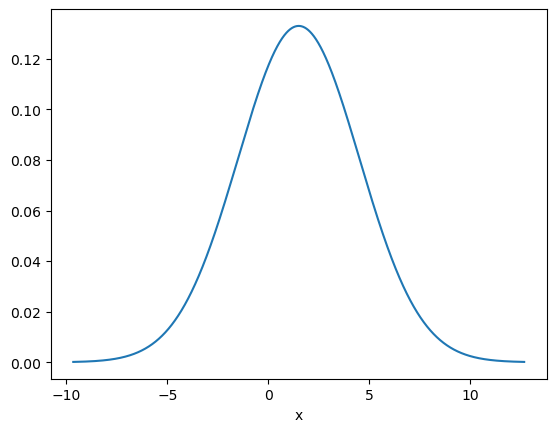

In [13]:
pdf.plot()

In [14]:
x.max()

12.657049456367126

In [15]:
x_bin_width = (x.max() - x.min())/len(x)

In [16]:
mean(pdf, pdf.x, dims='x', bin_widths={'x': x_bin_width})

<xarray.DataArray ()>
array(1.49955047)

In [17]:
standard_deviation(pdf, pdf.x, dims='x', bin_widths={'x': x_bin_width})

<xarray.DataArray ()>
array(2.99513617)

In [18]:
skewness(pdf, pdf.x, dims='x', bin_widths={'x': x_bin_width})

<xarray.DataArray ()>
array(0.00045026)